In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.combine import SMOTETomek
from sklearn.decomposition import FactorAnalysis
import seaborn as sns

# 1. Predicting Aggregate Measure with FA

Our aggregate measure of vascular risk is a discrete categorical variable. Therefore,
we considered that the optimal algorithm to predict it is a supervised learning model
for the classification of the aggregate measure, which values range from 0 to 5. In
addition, due to the imbalanced nature of our target variable, we considered that
the best algorithm to choose is Random Forest (RF) from the "ensemble" class in
Scikit-learn [1].

In [2]:
# Loading the data
data = pd.read_csv('casuality_data_final_factor_analyzer.csv')
data.shape

(2065, 1428)

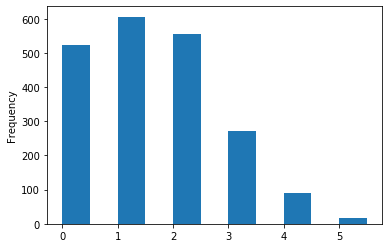

In [3]:
# Cardiovascular risk score
Y0 = data["agg_score"]
bin_values = np.arange(start=0, stop=6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [4]:
# Splitting each class from our target variable
S0 = data.loc[data['agg_score'] == 0]
S1 = data.loc[data['agg_score'] == 1]
S2 = data.loc[data['agg_score'] == 2]
S3 = data.loc[data['agg_score'] == 3]
S4 = data.loc[data['agg_score'] == 4]
S5 = data.loc[data['agg_score'] == 5]
S0.shape, S1.shape, S2.shape, S3.shape, S4.shape, S5.shape

((523, 1428), (606, 1428), (555, 1428), (273, 1428), (91, 1428), (17, 1428))

In [5]:
# Binarizing and concatenating our classes
S_0vs1 = pd.concat((S0, S1), axis=0)
S_0vs2 = pd.concat((S0, S2), axis=0)
S_0vs3 = pd.concat((S0, S3), axis=0)
S_0vs4 = pd.concat((S0, S4), axis=0)
S_0vs5 = pd.concat((S0, S5), axis=0)
S_0vs345 = pd.concat((S0, S3, S4, S5), axis=0)
S_0vs1.shape, S_0vs2.shape, S_0vs3.shape, S_0vs4.shape, S_0vs5.shape, S_0vs345.shape

((1129, 1428),
 (1078, 1428),
 (796, 1428),
 (614, 1428),
 (540, 1428),
 (904, 1428))

In [6]:
# Mapping values in binarized targets
S_0vs1["agg_score"] = S_0vs1["agg_score"].map({0:0, 1:1})
S_0vs2["agg_score"] = S_0vs2["agg_score"].map({0:0, 2:1})
S_0vs3["agg_score"] = S_0vs3["agg_score"].map({0:0, 3:1})
S_0vs4["agg_score"] = S_0vs4["agg_score"].map({0:0, 4:1})
S_0vs5["agg_score"] = S_0vs5["agg_score"].map({0:0, 5:1})
S_0vs345["agg_score"] = S_0vs345["agg_score"].map({0:0, 3:1, 4:1, 5:1})

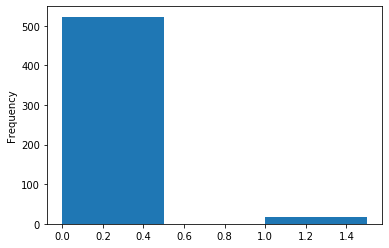

In [7]:
# Visualizing binary target class
Y0 = S_0vs5["agg_score"]
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [8]:
# Filtering data groups
heart_df = S_0vs5.filter(regex='heart')
cardio_cmr_df = S_0vs5.filter(regex='cardio_cmr')
brain_df = S_0vs5.filter(regex='brain')
heart_df.shape, brain_df.shape, cardio_cmr_df.shape

((540, 630), (540, 744), (540, 9))

In [9]:
# our model
RF = RandomForestClassifier()

This popular technique consists of a combination of decision trees (DTs) trained on
different random samples of the training set. Each DT is a set of rules based on the
input features values optimized for accurately classifying all elements of the training
set. DTs are nonlinear models and tend to have high variance

## 1.1 Predicting aggregate measure of vascular risk with heart variables

In [10]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df

SMOTE-TOMEK is a combination of over-sampling and under-sampling, where
SMOTE generates noisy samples by interpolating new points between marginal outliers and inliers, and Tomek’s cleans the space resulting from over-sampling

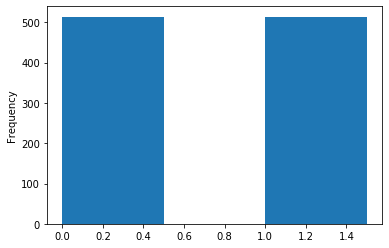

In [11]:
# transform the dataset
oversample = SMOTETomek()
X1, Y0 = oversample.fit_sample(X1, Y0)
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [12]:
# Dimensionality reduction
factor_heart = FactorAnalysis(n_components=5)
X_heart_cfa = factor_heart.fit_transform(X1, Y0)
X_heart_cfa.shape

(1028, 5)

In [13]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_heart_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((719, 5), (309, 5), (719,), (309,))

In [14]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9902912621359223

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       157
           1       0.98      1.00      0.99       152

    accuracy                           0.99       309
   macro avg       0.99      0.99      0.99       309
weighted avg       0.99      0.99      0.99       309



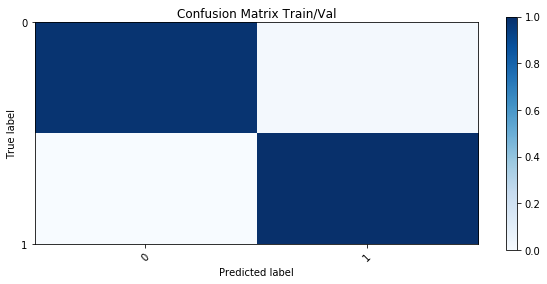

In [17]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [19]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [20]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.9973


In [21]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

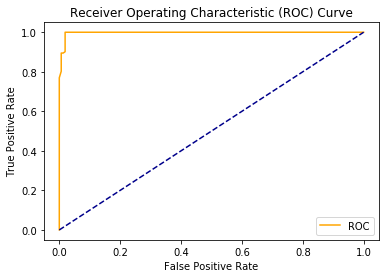

In [22]:
plot_roc_curve(fpr, tpr)

## 1.2 Predicting aggregate measure of vascular risk with CMR variables

In [23]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df

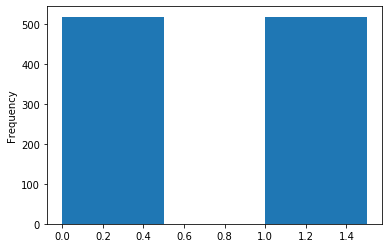

In [24]:
# transform the dataset
oversample = SMOTETomek()
X1, Y0 = oversample.fit_sample(X1, Y0)
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [25]:
# Dimensionality reduction
factor_cardio = FactorAnalysis(n_components=5)
X_cmr_cfa = factor_cardio.fit_transform(X1, Y0)
X_cmr_cfa.shape

(1038, 5)

In [26]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_cmr_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((726, 5), (312, 5), (726,), (312,))

In [27]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [28]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9487179487179487

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       162
           1       0.93      0.97      0.95       150

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



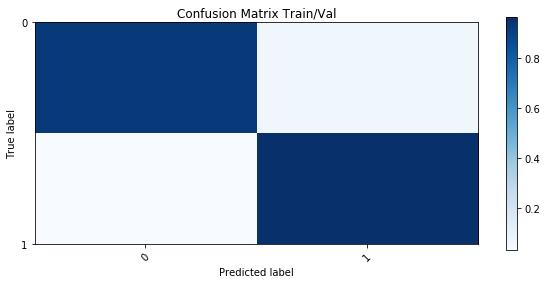

In [30]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [32]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [33]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.9916


In [34]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

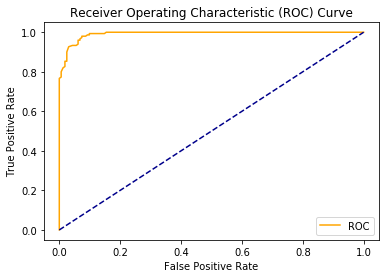

In [35]:
plot_roc_curve(fpr, tpr)

## 1.3 Predicting aggregate measure of vascular risk with brain variables

In [36]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = brain_df

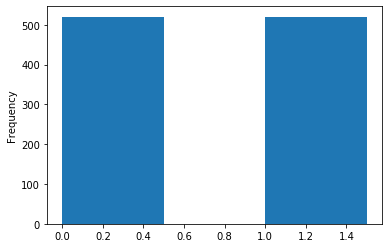

In [37]:
# transform the dataset
oversample = SMOTETomek()
X1, Y0 = oversample.fit_sample(X1, Y0)
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [38]:
# Dimensionality reduction
factor_brain = FactorAnalysis(n_components=5)
X_brain_cfa = factor_brain.fit_transform(X1, Y0)
X_brain_cfa.shape

(1040, 5)

In [39]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_brain_cfa, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((728, 5), (312, 5), (728,), (312,))

In [40]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [41]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9455128205128205

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       161
           1       0.93      0.96      0.94       151

    accuracy                           0.95       312
   macro avg       0.95      0.95      0.95       312
weighted avg       0.95      0.95      0.95       312



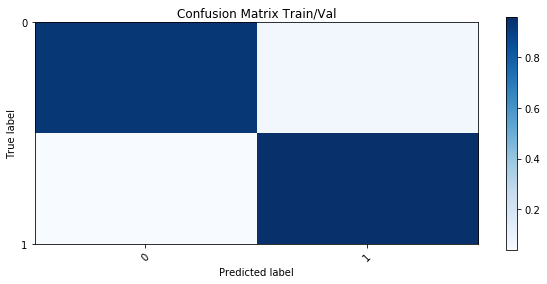

In [43]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [45]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.9801


In [46]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

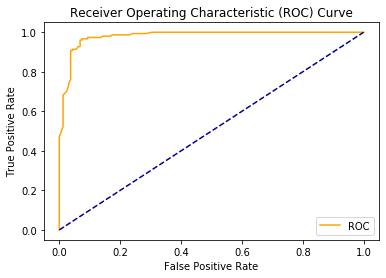

In [47]:
plot_roc_curve(fpr, tpr)

## 1.4 Predicting aggregate measure of vascular risk with heart/brain combinations

In [48]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = heart_df
X2 = brain_df
X1.shape, X2.shape

((540, 630), (540, 744))

In [49]:
# Combining datasets
X_combination_cfa = pd.concat((X1, X2), axis=1)
X_combination_cfa.shape

(540, 1374)

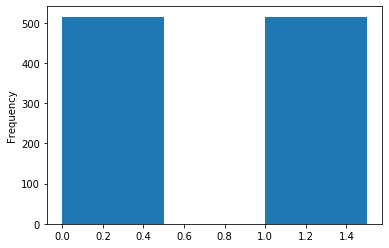

In [50]:
# transform the dataset
oversample = SMOTETomek()
X_combination_cfa, Y0 = oversample.fit_sample(X_combination_cfa, Y0)
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [51]:
# Dimensionality reduction
factor_1 = FactorAnalysis(n_components=5)
X__cfa_1 = factor_1.fit_transform(X_combination_cfa, Y0)
X__cfa_1.shape

(1030, 5)

In [52]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X__cfa_1, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((721, 5), (309, 5), (721,), (309,))

In [53]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9385113268608414

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       162
           1       0.92      0.96      0.94       147

    accuracy                           0.94       309
   macro avg       0.94      0.94      0.94       309
weighted avg       0.94      0.94      0.94       309



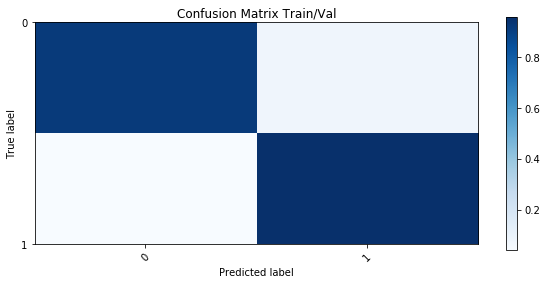

In [56]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [57]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [58]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.9782


In [59]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

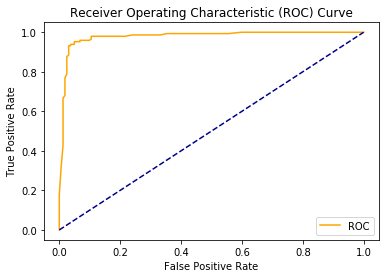

In [60]:
plot_roc_curve(fpr, tpr)

## 1.5 Predicting aggregate measure of vascular risk with CMR/brain combinations

In [61]:
# Input variables
Y0 = S_0vs5["agg_score"]
X1 = cardio_cmr_df
X2 = brain_df
X1.shape, X2.shape

((540, 9), (540, 744))

In [62]:
# Combining datasets
X_combination_cfa2 = pd.concat((X1, X2), axis=1)
X_combination_cfa2.shape

(540, 753)

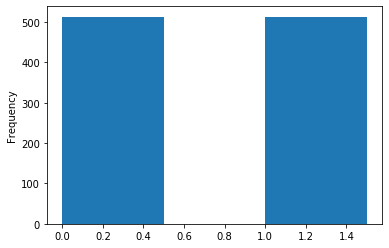

In [63]:
# transform the dataset
oversample = SMOTETomek()
X_combination_cfa2, Y0 = oversample.fit_sample(X_combination_cfa2, Y0)
bin_values = np.arange(start=0, stop=1.6, step=0.5)
Y0.plot(kind='hist', bins=bin_values)

In [64]:
# Dimensionality reduction
factor_2 = FactorAnalysis(n_components=5)
X_cfa_2 = factor_2.fit_transform(X_combination_cfa2, Y0)
X_cfa_2.shape

(1026, 5)

In [65]:
# Splitting our input data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X_cfa_2, Y0, test_size= 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((718, 5), (308, 5), (718,), (308,))

In [66]:
# Data normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Fitting the model and doing the predictions
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)
accuracy_score(y_test, y_pred)

0.9448051948051948

In [68]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       155
           1       0.91      0.98      0.95       153

    accuracy                           0.94       308
   macro avg       0.95      0.95      0.94       308
weighted avg       0.95      0.94      0.94       308



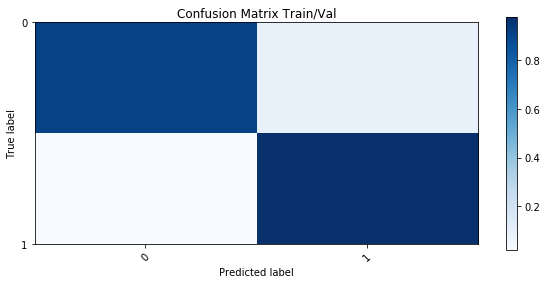

In [69]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,4))
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix Train/Val")
plt.colorbar()
plt.tight_layout()
tick_marks = np.arange(len(Y0.unique().tolist()))
plt.xticks(tick_marks, Y0.unique().tolist(), rotation=45)
plt.yticks(tick_marks, Y0.unique().tolist())
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [70]:
probs = RF.predict_proba(X_test)
probs = probs[:, 1]

In [71]:
# Compute the AUC Score.
auc = roc_auc_score(y_test, probs)
print('AUC: %.4f' % auc)

AUC: 0.9850


In [72]:
# Get the ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, probs)

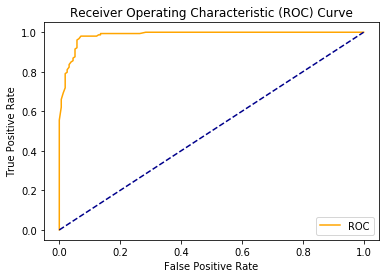

In [73]:
plot_roc_curve(fpr, tpr)

## 1.6 Correlation Plots

In [74]:
factor_heart.components_.shape, factor_cardio.components_.shape, factor_brain.components_.shape

((5, 630), (5, 9), (5, 744))

In [75]:
factor_1.components_.shape, factor_2.components_.shape

((5, 1374), (5, 753))

In [76]:
factor_heart_transposed = factor_heart.components_.T
factor_cardio_transposed = factor_cardio.components_.T
factor_brain_transposed = factor_brain.components_.T
factor_1_transposed = factor_1.components_.T
factor_2_transposed = factor_2.components_.T

In [77]:
factor_heart_transposed.shape, factor_cardio_transposed.shape, factor_brain_transposed.shape

((630, 5), (9, 5), (744, 5))

In [78]:
factor_1_transposed.shape, factor_2_transposed.shape

((1374, 5), (753, 5))

In [79]:
heart_components = pd.DataFrame(factor_heart_transposed, index=heart_df.columns)
cardio_components = pd.DataFrame(factor_cardio_transposed, index=cardio_cmr_df.columns)
brain_components = pd.DataFrame(factor_brain_transposed, index=brain_df.columns)
factor_1_components = pd.DataFrame(factor_1_transposed, index=X_combination_cfa.columns)
factor_2_components = pd.DataFrame(factor_2_transposed, index=X_combination_cfa2.columns)

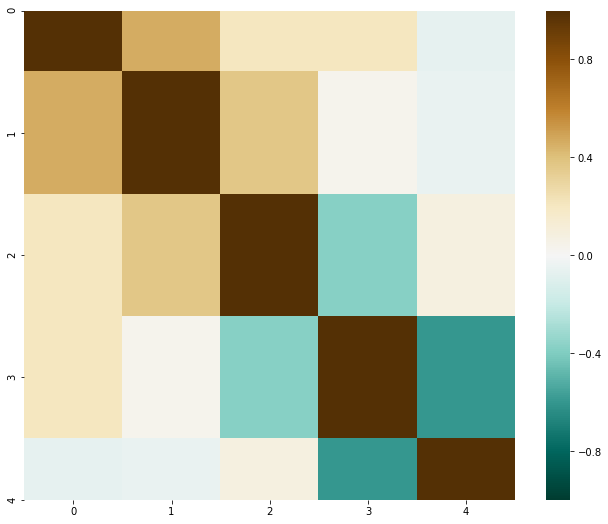

In [80]:
heart_corr = heart_components.corr()
plt.figure(figsize=(11,9))
sns.heatmap(heart_corr, cmap=plt.cm.BrBG_r, vmin=-1, vmax=1)
plt.show()

# 2. References

[1] [Pedregosa, F. et al. (2011)](https://www.jmlr.org/papers/volume12/pedregosa11a/pedregosa11a.pdf). Scikit-learn: Machine Learning in Python.